C:\Users\benlc\AppData\Local\Temp\ipykernel_6084\124096107.py:71: ComplexWarning: Casting complex values to real discards the imaginary part
  aligned_cube[i,:,:] = np.fft.fftshift(np.fft.ifft2(image_product))


[0.  0.1]
[0. 0.]
[0. 1.]
[0. 1.]
[0. 0.]
[ 0.  -0.1]
[0. 0.]
[0.  1.1]
[0. 1.]
[ 0.  -1.1]
[0. 0.]
[0. 0.]
[0.  0.6]
[0. 0.]
[0.  0.1]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.  1.1]
[0.  1.1]
[0. 0.]
[0. 0.]
[-63. 146.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.  1.1]
[0. 0.]
[0. 0.]
[0.  0.1]
[ 92.  118.9]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.  0.1]
[0. 1.]
[0. 0.]
[0. 0.]
[ 0.  -1.1]
[ 92.  118.9]
[-63. 146.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.  1.1]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0.  1.1]
[0. 0.]
[0. 0.]
[0.  0.2]
[ 0.  -0.8]
[0.  0.2]
[0. 0.]
[0. 0.]
[0.  0.6]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 1.]
[0.  0.1]
[0. 0.]
[0. 0.]
[0. 0.]
[ 0.  -0.5]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]
[0. 0.]


C:\Users\benlc\AppData\Local\Temp\ipykernel_6084\124096107.py:92: RuntimeWarning: All-NaN slice encountered
  med_derot = np.nanmedian(derotcube, axis=0)
C:\Users\benlc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


[724.22744696 352.40069392]


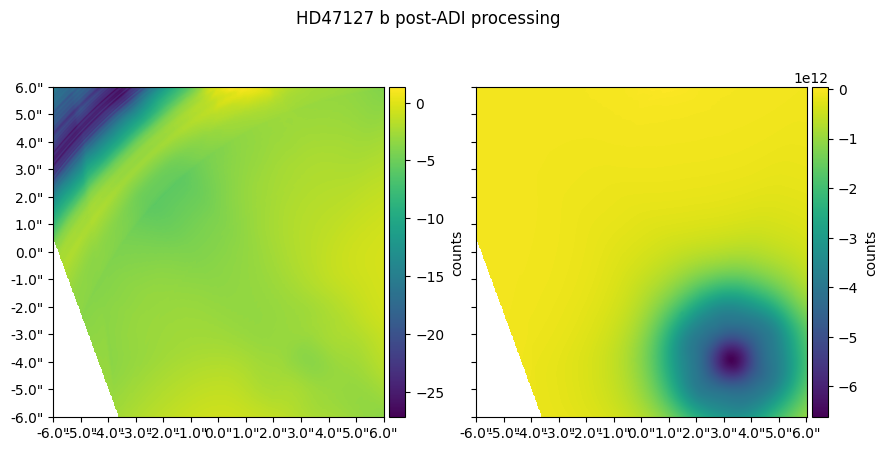

In [5]:
#import packages
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import glob
import pyklip
import pyklip.klip as klip
from pyklip.kpp.utils.mathfunc import *
from pyklip.kpp.metrics.crossCorr import calculate_cc
import astropy.units as u
from importlib import reload
from mpl_toolkits.axes_grid1 import make_axes_locatable
from pyklip.kpp.stat.stat_utils import get_image_stat_map
from skimage.registration import phase_cross_correlation
from skimage.registration._phase_cross_correlation import _upsampled_dft
from scipy.ndimage import shift
from photutils.centroids import centroid_2dg
%matplotlib inline

#define functions for display
def add_label(ax,txt,imsz):
    ax.text(5,imsz-10,txt,c='w',size=18)
    
def add_cbar(im,ax,f,lb="counts"):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right',size='5%',pad=0.05)
    f.colorbar(im,cax=cax,orientation='vertical',label=lb)
    
def set_display(stampsz,stampcen,tickint=1):
    mnx=int(stampcen[0]-stampsz/2)
    mxx=int(stampcen[0]+stampsz/2+1)
    mny=int(stampcen[1]-stampsz/2)
    mxy=int(stampcen[1]+stampsz/2+1)
    ranges=(mnx,mxx,mny,mxy)
    platescale=.02 ###for GPI its .01414
    nticks=np.floor(stampsz*platescale/2/tickint)
    ticklabels=np.arange(-1*nticks,nticks+1)*tickint
    ticklabels_str=[str(lab)+'\"' for lab in ticklabels]
    ticks = ticklabels/platescale + stampsz/2
    return(ranges,ticks,ticklabels_str)

#define ADI process
def cADI_NIRC2(flist, write_intermediate=False):
    
    #get data from fits, create raw image arrays
    rawcube = np.zeros((len(flist),1024,1024))
    aligned_cube = np.zeros((len(flist),1024,1024))
    cccube = np.zeros((1024,1024))
    subcube = np.zeros((len(flist),1024,1024))
    derotcube = np.zeros((len(flist),1024,1024))
    SNR_map = np.zeros((1024,1024))     
    ctrs=[]
    vertangs = []
    #ctrs = [502+np.argmax(np.mean(kernel_gauss,axis=0)),502+np.argmax(np.mean(kernel_gauss,axis=1))]

    for i in np.arange(len(flist)):
        rawcube[i,:,:] = fits.getdata(flist[i])
        fits.writeto('rawIMG.fits',rawcube[0,:,:],overwrite=True)
        head = fits.getheader(flist[i],ext=0)
        
        
        if i == 0:
            ctrs.append(centroid_2dg(rawcube[0,:,:],error=None,mask=None))
            aligned_cube[0,:,:] = rawcube[0,:,:]
            x_grid,y_grid= np.meshgrid(np.arange(-10,10),np.arange(-10,10))
            kernel_gauss = gauss2d(x_grid,y_grid, amplitude = 40.0, xo = 0, yo = 0, sigma_x = 1.0, sigma_y = 1.0)
        else:              
            shifts, error, diffphase = phase_cross_correlation(rawcube[0,:,:], rawcube[i,:,:],upsample_factor=10)
            image_product = np.fft.fft2(rawcube[0,:,:]) * np.fft.fft2(rawcube[i,:,:])
            aligned_cube[i,:,:] = np.fft.fftshift(np.fft.ifft2(image_product))
            #print(ctrs[0]-shift)
            print(shifts)
            #aligned_cube[i,:,:] = shift(rawcube[i,:,:],shifts)
            #image_product = np.fft.fft2(rawcube[0,:,:]) * np.fft.fft2(rawcube[i,:,:]).conj()
            #rawcube[i,:,:] = np.fft.fftshift(np.fft.ifft2(image_product))
            #rawcube[i,:,:] = _upsampled_dft(rawcube[i,:,:], 1024, 1024, (shift*100)+75).conj()

        va = head['ROTPPOSN'] #- head['INSTANGL'] + head['PARANG']
        vertangs.append(-va) ##check paper
        
    medcube = np.nanmedian(aligned_cube,axis=0)
    fits.writeto('medIMG.fits',medcube,overwrite=True)
    
    for i in np.arange(len(flist)):
        subcube[i,:,:] =  rawcube[i,:,:] - medcube
        derotcube[i,:,:] = klip.rotate(subcube[i,:,:], vertangs[i], ctrs[0], new_center=(512,512)) ##check tutorial
        
    fits.writeto('subIMG.fits',subcube[1,:,:],overwrite=True)
        
    #take median and return
    med_derot = np.nanmedian(derotcube, axis=0)
    fits.writeto('med_derotIMG.fits',med_derot,overwrite=True)
    cccube[:,:] = calculate_cc(med_derot[:,:],kernel_gauss,spectrum=None,nans2zero=True)
    SNR_map[:,:] = get_image_stat_map(cccube,
                                               centroid = ctrs[0],
                                               r_step=2,
                                               Dr = 2,
                                               type = "SNR")
    fits.writeto('snr_ccIMG.fits',SNR_map,overwrite=True)
    return SNR_map, med_derot, ctrs[0]


datadir = 'HD47127_data/Dec_2023/'
flist = sorted(glob.glob(datadir + '*.fits'))

flist_adi, med, cen = cADI_NIRC2(flist, write_intermediate=False)
print(cen)
stampsz = 600
rg, ticks, ticklabels_str = set_display(stampsz, stampcen=cen)
(mnx,mxx,mny,mxy) = rg


f,(ax1, ax2) = plt.subplots(1,2,sharex=True,sharey=True,figsize=(10,5))
f.suptitle("HD47127 b post-ADI processing")
im1 = ax1.imshow(flist_adi[mnx:mxx,mny:mxy],origin='lower')
im2 = ax2.imshow(med[mnx:mxx,mny:mxy],origin='lower')
plt.xticks(ticks,labels=ticklabels_str)
plt.yticks(ticks,labels=ticklabels_str)
add_cbar(im1,ax1,f)
add_cbar(im2,ax2,f)

#NAXIS: num of axes
#NAXIS1: length of axis
#RA
#DEC
#TARGRA
#TARGDEC
#RAOFF, DECOFF: DCS RA, Dec offset
#PARANG: parallactic angle astrometric
#CENWAVE: central wavelength of passband
#MINWAVE, MAXWAVE
#EFFWAVE: effective wavelength of passband
#LTM1_1, LTM2_2, CD1_1, CD1_2, CD2_1, CD2_2
#ELAPTIME: total integration time
#PSFCX, PSFCY: center of PSF in pixels
#STARCX, STARCY: center of star in pixels
#PIXSCALE, PIXSCAL1, PIXSCAL2: arcsec per pixel


